# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
!mkdir -p data
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.67KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

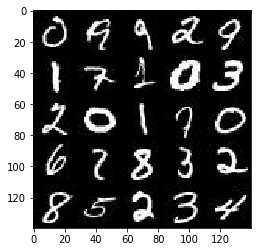

In [1]:
show_n_images = 25
data_dir = './data'
import helper

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

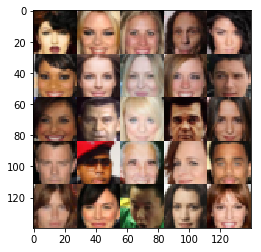

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [4]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="real_input")
    z_input = tf.placeholder(tf.float32, [None, z_dim], name="z_input")
    l_rate = tf.placeholder(tf.float32, name="l_rate")

    return real_input, z_input, l_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [26]:
import numpy as np
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):        
        #Input is 28x28x3
        x = tf.layers.conv2d(images, filters=32, kernel_size=4, strides=1, padding="same")
        x = tf.maximum(alpha * x, x, "input")
        # 28x28x32
        
        #print(x.shape)
        
        cl0 = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding="same")
        cl0 = tf.layers.batch_normalization(cl0, training=True)
        cl0 = tf.maximum(alpha * cl0, cl0, "cl0")
        # 14x14x64
        
        cl1 = tf.layers.conv2d(cl0, filters=128, kernel_size=4, strides=2, padding="same")
        cl1 = tf.layers.batch_normalization(cl1, training=True)
        cl1 = tf.maximum(alpha * cl1, cl1, "cl1")
        # 7x7x128
        
        #print(cl1.shape)
        
        cl2 = tf.layers.conv2d(cl1, filters=256, kernel_size=4, strides=2, padding="same")
        cl2 = tf.layers.batch_normalization(cl2, training=True)
        cl2 = tf.maximum(alpha * cl2, cl2, "cl2")
        # 4x4x256
        
        #print(cl2.shape)
        
        cl3 = tf.layers.conv2d(cl2, filters=512, kernel_size=4, strides=2, padding="same")
        cl3 = tf.layers.batch_normalization(cl3, training=True)
        cl3 = tf.maximum(alpha * cl3, cl3, "cl3")
        # 2x2x512
        
        #print(cl3.shape)
        
        #cl4 = tf.layers.conv2d(cl3, filters=512, kernel_size=4, strides=2, padding="same")
        #cl4 = tf.layers.batch_normalization(cl4, training=True)
        #cl4 = tf.maximum(alpha * cl4, cl4, "cl4")
        # 7x7x512

        # Flatten it
        flat = tf.reshape(cl3, (-1, int(np.prod(cl3.shape[1:]))))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [27]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function

    with tf.variable_scope("generator", reuse=not is_train):
        # First fully connected layer
        x = tf.layers.dense(z, 4*4*512)
        x = tf.reshape(x, (-1, 4, 4, 512))
        x = tf.layers.batch_normalization(x, training=not is_train)
        # Leaky ReLU
        x = tf.maximum(alpha * x, x, "input")
        # 4x4x512 now
        
        #print(x.shape)
        
        cl1 = tf.image.resize_images(x, [14, 14], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        cl1 = tf.pad(cl1, [[0, 0], [1, 1,], [1, 1], [0, 0]], "SYMMETRIC")
        cl1 = tf.layers.conv2d(cl1, 256, 4, 2, 'same')
        #cl1 = tf.layers.conv2d_transpose(x, 256, 4, 2, 'same')
        cl1 = tf.layers.batch_normalization(cl1, training=not is_train)
        cl1 = tf.maximum(alpha * cl1, cl1, "cl1")
        # 8x8x256 now
        
        #print(cl1.shape)
        
        cl2 = tf.image.resize_images(cl1, [30, 30], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        cl2 = tf.pad(cl2, [[0, 0], [1, 1,], [1, 1], [0, 0]], "SYMMETRIC")
        cl2 = tf.layers.conv2d(cl2, 128, 4, 2, 'same')
        #cl2 = tf.layers.conv2d_transpose(cl1, 128, 4, 2, 'same')
        cl2 = tf.layers.batch_normalization(cl2, training=not is_train)
        cl2 = tf.maximum(alpha * cl2, cl2, "cl2")
        # 16x16x128 now
        
        #print(cl2.shape)
        
        cl3 = tf.image.resize_images(cl2, [54, 54]) #, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        cl3 = tf.pad(cl3, [[0, 0], [1, 1,], [1, 1], [0, 0]], "SYMMETRIC")
        cl3 = tf.layers.conv2d(cl3, 64, 4, 2, 'same')
        #cl3 = tf.layers.conv2d_transpose(cl3, 64, 4, 2, 'same')
        cl3 = tf.layers.batch_normalization(cl3, training=not is_train)
        cl3 = tf.maximum(alpha * cl3, cl3, "cl3")
        # 28x28x64 now
        
        #print(cl3.shape)
        
        #cl4 = tf.layers.conv2d_transpose(cl3, 32, 5, 2, 'same')
        #cl4 = tf.layers.batch_normalization(cl4, training=not is_train)
        #cl4 = tf.maximum(alpha * cl4, cl4, "cl3")
        # 32x32x32 now
        
        # Output layer, 28x28xout_channel_dim
        #logits = tf.image.resize_images(cl3, [54, 54], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        #logits = tf.pad(logits, [[0, 0], [1, 1,], [1, 1], [0, 0]], "SYMMETRIC")
        #logits = tf.layers.conv2d(cl3, out_channel_dim, 4, 2, 'same')
        logits = tf.layers.conv2d_transpose(cl3, out_channel_dim, 4, 1, 'same')
        
        #print(logits.shape)
        
        out = tf.tanh(logits)
        #out = tf.image.resize_images(out, [28, 28])
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [21]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function 
    # Taken as is from the DCGAN lesson
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [22]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    # Taken as is from the DCGAN lesson
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [24]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
                           print_every = 10, draw_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    losses = []
    
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    if data_image_mode == "RGB":
        channels = 3
    elif data_image_mode == "L":
        channels = 1
    else:
        assert False, "Image mode not recognised."
        
    steps = 0
   
    # Building the Model
    real_input, z_input, l_rate = model_inputs(data_shape[1], data_shape[2], channels, z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, l_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images * 2
                # TODO: Train Model               
                
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input: batch_z, l_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input: batch_z, real_input: batch_images, l_rate: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_input: batch_z, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % draw_every == 0:
                    show_generator_output(sess, 25, z_input, channels, data_image_mode)
        show_generator_output(sess, 25, z_input, channels, data_image_mode)
                    
        return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2327... Generator Loss: 4.8130
Epoch 1/2... Discriminator Loss: 1.0930... Generator Loss: 5.1084
Epoch 1/2... Discriminator Loss: 0.1134... Generator Loss: 3.3454
Epoch 1/2... Discriminator Loss: 7.1496... Generator Loss: 12.1818
Epoch 1/2... Discriminator Loss: 0.8947... Generator Loss: 0.7994
Epoch 1/2... Discriminator Loss: 0.3413... Generator Loss: 3.2532
Epoch 1/2... Discriminator Loss: 1.1725... Generator Loss: 4.9049
Epoch 1/2... Discriminator Loss: 1.9936... Generator Loss: 5.7731
Epoch 1/2... Discriminator Loss: 1.0891... Generator Loss: 4.6662
Epoch 1/2... Discriminator Loss: 0.8400... Generator Loss: 0.8565


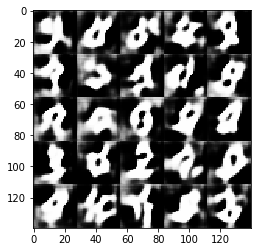

Epoch 1/2... Discriminator Loss: 1.1475... Generator Loss: 0.6469
Epoch 1/2... Discriminator Loss: 0.6108... Generator Loss: 2.9480
Epoch 1/2... Discriminator Loss: 0.4183... Generator Loss: 1.6741
Epoch 1/2... Discriminator Loss: 0.5306... Generator Loss: 1.5819
Epoch 1/2... Discriminator Loss: 0.5657... Generator Loss: 1.4645
Epoch 1/2... Discriminator Loss: 1.6318... Generator Loss: 0.3369
Epoch 1/2... Discriminator Loss: 0.7324... Generator Loss: 1.0966
Epoch 1/2... Discriminator Loss: 0.5941... Generator Loss: 1.6599
Epoch 1/2... Discriminator Loss: 0.4325... Generator Loss: 1.9937
Epoch 1/2... Discriminator Loss: 0.8221... Generator Loss: 0.8022


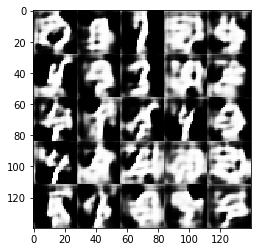

Epoch 1/2... Discriminator Loss: 0.8222... Generator Loss: 3.9214
Epoch 1/2... Discriminator Loss: 0.6050... Generator Loss: 1.5636
Epoch 1/2... Discriminator Loss: 0.7672... Generator Loss: 0.9687
Epoch 1/2... Discriminator Loss: 1.6367... Generator Loss: 0.4546
Epoch 1/2... Discriminator Loss: 0.5607... Generator Loss: 1.3248
Epoch 1/2... Discriminator Loss: 0.6245... Generator Loss: 1.9285
Epoch 1/2... Discriminator Loss: 0.5597... Generator Loss: 1.1836
Epoch 1/2... Discriminator Loss: 0.6402... Generator Loss: 2.3544
Epoch 1/2... Discriminator Loss: 0.7964... Generator Loss: 0.8490
Epoch 1/2... Discriminator Loss: 1.1461... Generator Loss: 0.6077


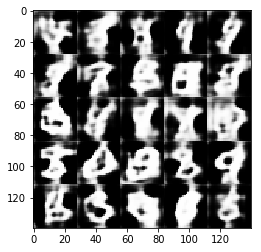

Epoch 1/2... Discriminator Loss: 0.6052... Generator Loss: 1.3356
Epoch 1/2... Discriminator Loss: 0.5409... Generator Loss: 1.7807
Epoch 1/2... Discriminator Loss: 0.5238... Generator Loss: 1.4512
Epoch 1/2... Discriminator Loss: 2.7931... Generator Loss: 0.1180
Epoch 1/2... Discriminator Loss: 0.6720... Generator Loss: 0.9841
Epoch 1/2... Discriminator Loss: 1.3875... Generator Loss: 0.3929
Epoch 1/2... Discriminator Loss: 1.7041... Generator Loss: 0.2899
Epoch 1/2... Discriminator Loss: 0.5778... Generator Loss: 1.1738
Epoch 1/2... Discriminator Loss: 1.0485... Generator Loss: 0.5579
Epoch 1/2... Discriminator Loss: 0.7702... Generator Loss: 1.8783


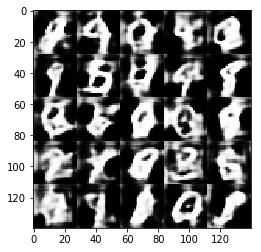

Epoch 1/2... Discriminator Loss: 0.7587... Generator Loss: 0.8405
Epoch 1/2... Discriminator Loss: 1.4999... Generator Loss: 0.3311
Epoch 1/2... Discriminator Loss: 0.8613... Generator Loss: 0.7200
Epoch 1/2... Discriminator Loss: 0.9392... Generator Loss: 0.6743
Epoch 1/2... Discriminator Loss: 0.8877... Generator Loss: 0.9454
Epoch 1/2... Discriminator Loss: 0.9903... Generator Loss: 2.3428
Epoch 1/2... Discriminator Loss: 0.9542... Generator Loss: 0.7056
Epoch 1/2... Discriminator Loss: 1.2536... Generator Loss: 0.4579
Epoch 1/2... Discriminator Loss: 0.7665... Generator Loss: 1.1745
Epoch 1/2... Discriminator Loss: 0.8991... Generator Loss: 1.4881


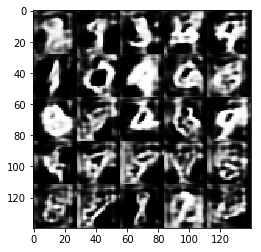

Epoch 1/2... Discriminator Loss: 0.8557... Generator Loss: 1.0432
Epoch 1/2... Discriminator Loss: 0.7901... Generator Loss: 1.4138
Epoch 1/2... Discriminator Loss: 1.1815... Generator Loss: 0.5240
Epoch 1/2... Discriminator Loss: 0.4479... Generator Loss: 1.4498
Epoch 1/2... Discriminator Loss: 0.7207... Generator Loss: 1.0654
Epoch 1/2... Discriminator Loss: 0.7306... Generator Loss: 0.9437
Epoch 1/2... Discriminator Loss: 0.4580... Generator Loss: 1.7162
Epoch 1/2... Discriminator Loss: 0.4889... Generator Loss: 1.4641
Epoch 1/2... Discriminator Loss: 1.1945... Generator Loss: 0.5179
Epoch 1/2... Discriminator Loss: 0.6945... Generator Loss: 0.8863


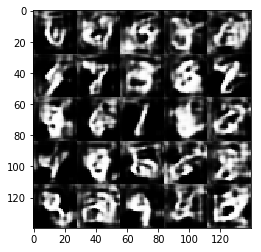

Epoch 1/2... Discriminator Loss: 1.0233... Generator Loss: 0.6354
Epoch 1/2... Discriminator Loss: 0.9671... Generator Loss: 3.8613
Epoch 1/2... Discriminator Loss: 0.9254... Generator Loss: 0.8399
Epoch 1/2... Discriminator Loss: 0.8782... Generator Loss: 0.6597
Epoch 1/2... Discriminator Loss: 0.6545... Generator Loss: 1.0078
Epoch 1/2... Discriminator Loss: 0.3428... Generator Loss: 1.7022
Epoch 1/2... Discriminator Loss: 0.4707... Generator Loss: 1.2481
Epoch 1/2... Discriminator Loss: 0.5726... Generator Loss: 1.0143
Epoch 1/2... Discriminator Loss: 0.2667... Generator Loss: 1.7732
Epoch 1/2... Discriminator Loss: 0.1986... Generator Loss: 2.0934


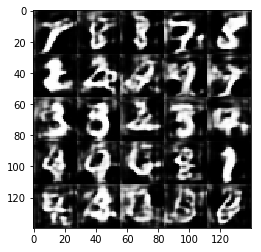

Epoch 1/2... Discriminator Loss: 0.5832... Generator Loss: 1.0615
Epoch 1/2... Discriminator Loss: 1.8424... Generator Loss: 5.7320
Epoch 1/2... Discriminator Loss: 0.9854... Generator Loss: 0.6138
Epoch 1/2... Discriminator Loss: 1.0616... Generator Loss: 0.5184
Epoch 1/2... Discriminator Loss: 0.7656... Generator Loss: 0.8180
Epoch 1/2... Discriminator Loss: 0.8675... Generator Loss: 0.7118
Epoch 1/2... Discriminator Loss: 0.7400... Generator Loss: 0.9238
Epoch 1/2... Discriminator Loss: 0.6391... Generator Loss: 0.9857
Epoch 1/2... Discriminator Loss: 3.9879... Generator Loss: 0.1082
Epoch 1/2... Discriminator Loss: 1.8118... Generator Loss: 0.3642


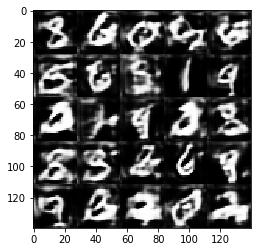

Epoch 1/2... Discriminator Loss: 0.5415... Generator Loss: 1.2955
Epoch 1/2... Discriminator Loss: 0.7630... Generator Loss: 0.8599
Epoch 1/2... Discriminator Loss: 0.4767... Generator Loss: 1.1920
Epoch 1/2... Discriminator Loss: 0.9053... Generator Loss: 0.6630
Epoch 1/2... Discriminator Loss: 1.0425... Generator Loss: 0.5530
Epoch 1/2... Discriminator Loss: 0.5360... Generator Loss: 2.0456
Epoch 1/2... Discriminator Loss: 1.1481... Generator Loss: 0.5486
Epoch 1/2... Discriminator Loss: 0.6305... Generator Loss: 1.0800
Epoch 1/2... Discriminator Loss: 0.4696... Generator Loss: 1.2872
Epoch 1/2... Discriminator Loss: 0.5422... Generator Loss: 1.1299


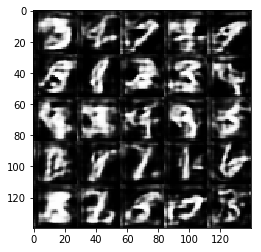

Epoch 1/2... Discriminator Loss: 0.8772... Generator Loss: 0.6918
Epoch 1/2... Discriminator Loss: 0.2002... Generator Loss: 4.7616
Epoch 1/2... Discriminator Loss: 0.5479... Generator Loss: 2.1652
Epoch 2/2... Discriminator Loss: 0.9578... Generator Loss: 0.6120
Epoch 2/2... Discriminator Loss: 0.4745... Generator Loss: 1.4888
Epoch 2/2... Discriminator Loss: 0.6325... Generator Loss: 0.9338
Epoch 2/2... Discriminator Loss: 0.6236... Generator Loss: 0.8788
Epoch 2/2... Discriminator Loss: 0.6182... Generator Loss: 0.9894
Epoch 2/2... Discriminator Loss: 0.2445... Generator Loss: 1.9180
Epoch 2/2... Discriminator Loss: 0.4631... Generator Loss: 1.2499


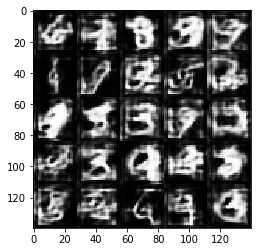

Epoch 2/2... Discriminator Loss: 0.0945... Generator Loss: 3.1067
Epoch 2/2... Discriminator Loss: 0.3167... Generator Loss: 1.5817
Epoch 2/2... Discriminator Loss: 0.5733... Generator Loss: 1.0929


KeyboardInterrupt: 

In [25]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.1906... Generator Loss: 2.6595
Epoch 1/1... Discriminator Loss: 0.3865... Generator Loss: 1.8106
Epoch 1/1... Discriminator Loss: 0.1036... Generator Loss: 3.0592
Epoch 1/1... Discriminator Loss: 0.1425... Generator Loss: 3.3977
Epoch 1/1... Discriminator Loss: 0.1189... Generator Loss: 3.2267
Epoch 1/1... Discriminator Loss: 0.3148... Generator Loss: 2.2355
Epoch 1/1... Discriminator Loss: 0.2683... Generator Loss: 2.3513
Epoch 1/1... Discriminator Loss: 0.3997... Generator Loss: 3.7827
Epoch 1/1... Discriminator Loss: 0.8184... Generator Loss: 0.9837
Epoch 1/1... Discriminator Loss: 0.2052... Generator Loss: 2.4988


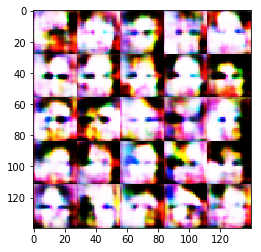

Epoch 1/1... Discriminator Loss: 0.2541... Generator Loss: 2.4016
Epoch 1/1... Discriminator Loss: 0.1270... Generator Loss: 3.3969
Epoch 1/1... Discriminator Loss: 0.1615... Generator Loss: 6.0003
Epoch 1/1... Discriminator Loss: 0.2501... Generator Loss: 2.5473
Epoch 1/1... Discriminator Loss: 0.3107... Generator Loss: 2.4244
Epoch 1/1... Discriminator Loss: 0.2999... Generator Loss: 2.0139
Epoch 1/1... Discriminator Loss: 0.1789... Generator Loss: 3.9582
Epoch 1/1... Discriminator Loss: 0.1859... Generator Loss: 4.7618
Epoch 1/1... Discriminator Loss: 0.1282... Generator Loss: 4.3283
Epoch 1/1... Discriminator Loss: 0.1090... Generator Loss: 4.1432


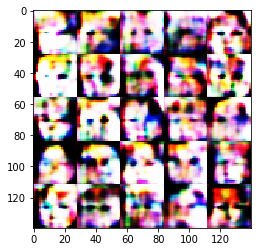

Epoch 1/1... Discriminator Loss: 0.3440... Generator Loss: 3.6585
Epoch 1/1... Discriminator Loss: 0.2983... Generator Loss: 6.8085
Epoch 1/1... Discriminator Loss: 0.4276... Generator Loss: 1.9560
Epoch 1/1... Discriminator Loss: 0.2642... Generator Loss: 3.0996
Epoch 1/1... Discriminator Loss: 0.2639... Generator Loss: 2.3367
Epoch 1/1... Discriminator Loss: 0.5259... Generator Loss: 1.3446
Epoch 1/1... Discriminator Loss: 0.5264... Generator Loss: 1.5633
Epoch 1/1... Discriminator Loss: 0.4308... Generator Loss: 1.9501
Epoch 1/1... Discriminator Loss: 0.8380... Generator Loss: 8.0227
Epoch 1/1... Discriminator Loss: 0.4262... Generator Loss: 2.2456


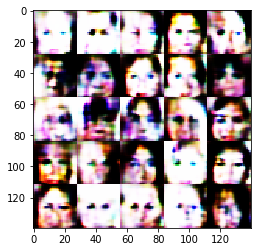

Epoch 1/1... Discriminator Loss: 0.3742... Generator Loss: 2.4520
Epoch 1/1... Discriminator Loss: 0.2305... Generator Loss: 2.8349
Epoch 1/1... Discriminator Loss: 0.2493... Generator Loss: 2.3097
Epoch 1/1... Discriminator Loss: 0.2627... Generator Loss: 2.3136
Epoch 1/1... Discriminator Loss: 0.2564... Generator Loss: 2.4152
Epoch 1/1... Discriminator Loss: 0.3244... Generator Loss: 4.1485
Epoch 1/1... Discriminator Loss: 0.2566... Generator Loss: 3.1597
Epoch 1/1... Discriminator Loss: 0.2081... Generator Loss: 3.5617
Epoch 1/1... Discriminator Loss: 0.3094... Generator Loss: 5.4012
Epoch 1/1... Discriminator Loss: 0.2277... Generator Loss: 2.7964


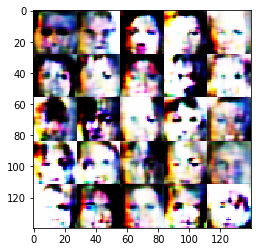

Epoch 1/1... Discriminator Loss: 0.2546... Generator Loss: 2.7415
Epoch 1/1... Discriminator Loss: 0.3328... Generator Loss: 3.0041
Epoch 1/1... Discriminator Loss: 0.8063... Generator Loss: 1.1332
Epoch 1/1... Discriminator Loss: 0.3702... Generator Loss: 2.2183
Epoch 1/1... Discriminator Loss: 0.2383... Generator Loss: 3.0077
Epoch 1/1... Discriminator Loss: 0.2427... Generator Loss: 3.0025
Epoch 1/1... Discriminator Loss: 0.9174... Generator Loss: 0.9774
Epoch 1/1... Discriminator Loss: 0.3581... Generator Loss: 2.1193
Epoch 1/1... Discriminator Loss: 0.1804... Generator Loss: 3.1530
Epoch 1/1... Discriminator Loss: 0.4152... Generator Loss: 1.6412


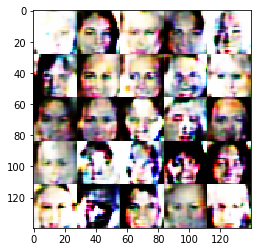

Epoch 1/1... Discriminator Loss: 0.2641... Generator Loss: 2.7651
Epoch 1/1... Discriminator Loss: 0.4585... Generator Loss: 3.5268
Epoch 1/1... Discriminator Loss: 0.3124... Generator Loss: 2.7340
Epoch 1/1... Discriminator Loss: 0.2095... Generator Loss: 4.1198
Epoch 1/1... Discriminator Loss: 0.2693... Generator Loss: 3.5927
Epoch 1/1... Discriminator Loss: 0.5626... Generator Loss: 1.4534
Epoch 1/1... Discriminator Loss: 0.6374... Generator Loss: 1.1475
Epoch 1/1... Discriminator Loss: 0.2359... Generator Loss: 3.1102
Epoch 1/1... Discriminator Loss: 0.2458... Generator Loss: 2.9229
Epoch 1/1... Discriminator Loss: 0.4609... Generator Loss: 1.8436


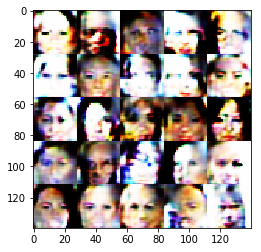

Epoch 1/1... Discriminator Loss: 0.2794... Generator Loss: 2.5575
Epoch 1/1... Discriminator Loss: 0.3395... Generator Loss: 1.9613
Epoch 1/1... Discriminator Loss: 0.3138... Generator Loss: 2.1877
Epoch 1/1... Discriminator Loss: 0.4723... Generator Loss: 1.4020
Epoch 1/1... Discriminator Loss: 0.2434... Generator Loss: 3.6202
Epoch 1/1... Discriminator Loss: 0.3344... Generator Loss: 2.3551
Epoch 1/1... Discriminator Loss: 0.7266... Generator Loss: 5.2142
Epoch 1/1... Discriminator Loss: 0.6469... Generator Loss: 1.3815
Epoch 1/1... Discriminator Loss: 0.2170... Generator Loss: 2.3967
Epoch 1/1... Discriminator Loss: 0.2544... Generator Loss: 2.6191


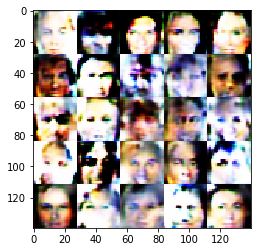

Epoch 1/1... Discriminator Loss: 0.3233... Generator Loss: 2.0599
Epoch 1/1... Discriminator Loss: 0.3258... Generator Loss: 2.1255
Epoch 1/1... Discriminator Loss: 0.6730... Generator Loss: 4.1133
Epoch 1/1... Discriminator Loss: 0.2085... Generator Loss: 3.0253
Epoch 1/1... Discriminator Loss: 0.4548... Generator Loss: 1.7157
Epoch 1/1... Discriminator Loss: 0.3350... Generator Loss: 2.7999
Epoch 1/1... Discriminator Loss: 0.3414... Generator Loss: 2.1059
Epoch 1/1... Discriminator Loss: 0.3716... Generator Loss: 1.7994
Epoch 1/1... Discriminator Loss: 0.3822... Generator Loss: 2.0283
Epoch 1/1... Discriminator Loss: 0.3987... Generator Loss: 2.3155


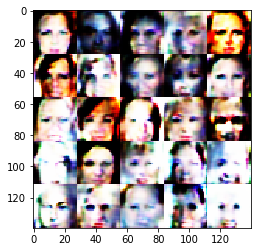

Epoch 1/1... Discriminator Loss: 0.4153... Generator Loss: 1.8739
Epoch 1/1... Discriminator Loss: 0.2646... Generator Loss: 2.5232
Epoch 1/1... Discriminator Loss: 0.3863... Generator Loss: 1.6591
Epoch 1/1... Discriminator Loss: 0.3653... Generator Loss: 2.0122
Epoch 1/1... Discriminator Loss: 0.3109... Generator Loss: 2.0036
Epoch 1/1... Discriminator Loss: 0.3549... Generator Loss: 1.9719
Epoch 1/1... Discriminator Loss: 0.3729... Generator Loss: 1.7454
Epoch 1/1... Discriminator Loss: 0.2754... Generator Loss: 2.2609
Epoch 1/1... Discriminator Loss: 0.4221... Generator Loss: 1.6809
Epoch 1/1... Discriminator Loss: 0.4995... Generator Loss: 1.4470


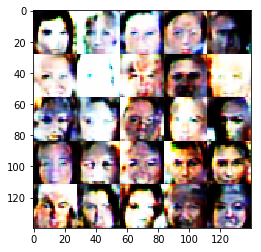

Epoch 1/1... Discriminator Loss: 0.5580... Generator Loss: 1.2262
Epoch 1/1... Discriminator Loss: 0.3430... Generator Loss: 2.3059
Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 5.7973
Epoch 1/1... Discriminator Loss: 0.4023... Generator Loss: 1.8916
Epoch 1/1... Discriminator Loss: 0.5646... Generator Loss: 1.2348
Epoch 1/1... Discriminator Loss: 0.7098... Generator Loss: 1.0844


KeyboardInterrupt: 

In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.